In [1]:
import os
import json
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from visualizations.solution_visualization import plot_gantt_chart, plot_robot_trajectories
from helper_functions.schedules import Full_Horizon_Schedule


### Dataset of exact solutions of Full_Horizon_Schedules

In [2]:
def load_dataset(problem_dir, solution_dir):
    problems = []
    solutions = []
    
    # Load all problem instances
    for file_name in sorted(os.listdir(problem_dir)):
        with open(os.path.join(problem_dir, file_name), "r") as f:
            problems.append(json.load(f))
    
    # Load all solution files
    for file_name in sorted(os.listdir(solution_dir)):
        with open(os.path.join(solution_dir, file_name), "r") as f:
            solutions.append(json.load(f))
    
    solutions = [Full_Horizon_Schedule.from_dict(solution) for solution in solutions]
    
    return problems, solutions

In [3]:
# Define paths
problem_dir = "/home/jakob/thesis/datasets/simple_dataset_1000/problem_instances"
solution_dir = "/home/jakob/thesis/datasets/simple_dataset_1000/solutions"

# Load dataset
problems, solutions = load_dataset(problem_dir, solution_dir)

IntSlider(value=0, continuous_update=False, description='Solution:', max=999)

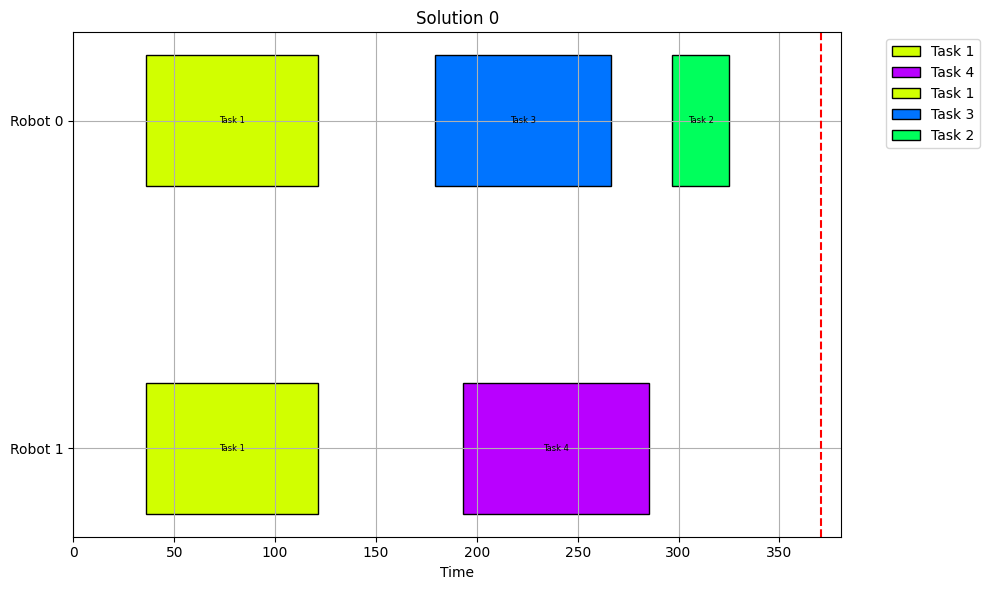

Schedule:
  Number of tasks: 4
  Number of robots: 2
  Makespan/Arrival at end location: 370.50
  Robot Tasks:
    Robot 0:
      Task 1: 36.10 -> 121.10
      Task 3: 179.40 -> 266.40
      Task 2: 296.90 -> 324.90
    Robot 1:
      Task 1: 36.10 -> 121.10
      Task 4: 193.40 -> 285.40

[  0. 122. 267. 286. 325.]


In [45]:
def update_plot(change):
    """Update the Gantt chart when the slider value changes."""
    index = slider.value  # Get the current slider value
    solution = solutions[index]
    clear_output(wait=True)  # Clear previous output
    display(slider)  # Re-display the slider
    plot_gantt_chart(f"Solution {index}", solution)  # Plot the updated Gantt chart
    print(f"{solutions[index]}")
    print(find_decision_points(solutions[index]))

# Create the slider
slider = widgets.IntSlider(
    value=0,  # Default starting index
    min=0,    # Minimum index
    max=len(solutions) - 1,  # Maximum index based on solutions size
    step=1,   # Step size for the slider
    description='Solution:',
    continuous_update=False, # Update only when the slider is released
    )

# Attach the update function to the slider's change event
slider.observe(update_plot, names='value')

update_plot(None)  # Display the initial plot


### Slice the dataset into instantaneous assignments for training

In [11]:
solutions[0].robot_schedules

{0: [(1, 36.1, 121.1), (3, 179.4, 266.4), (2, 296.9, 324.9)],
 1: [(1, 36.1, 121.1), (4, 193.4, 285.4)]}

In [44]:
def find_decision_points(solution):
    end_time_index = 2
    end_times_of_tasks = np.array([task[end_time_index] for tasks in solution.robot_schedules.values() for task in tasks])
    decision_points = np.unique(end_times_of_tasks)

    # Also beginning of mission is decsision point --> append 0
    return np.ceil(np.append([0],decision_points))

### Extract expert rewards at decision points

In [63]:
def extract_expert_reward(schedule, decision_time, gamma = 0.99):
    """
    schedule: dict {robot_id: [(task_id, start_time, end_time), ...]}
    decision_time: float
    gamma: float discount factor
    Returns:
      E: Expert reward matrix[n_robots, n_tasks]
      X: Feasibility mask  [n_robots, n_tasks]
    Assumptions:
      - For now no precedence constraints --> tasks are ready or completed 
      - Task completion can be inferred from the intervals
      - Robots are identified by keys in `schedule`
      - Tasks are the unique set of all task_ids in all intervals
    """


    n_robots = len(schedule)
    task_ids = sorted({t_id for r_id in schedule for (t_id, _, _) in schedule[r_id]})


    E = np.zeros((n_robots, len(task_ids))) 
    X = np.zeros((n_robots, len(task_ids)))


    def is_idle(robot_id, time):
        for t_id, task_start, task_end in schedule[robot_id]:
            if task_start <= time <= task_end:
                return False
        return True


    for robot_id in schedule.keys():
        if is_idle(robot_id, decision_time):
            # Robot task pair is feasible at decision time 
            X[robot_id, :] = 1

        for task_id, start_time, end_time in schedule[robot_id]:
            # Task is completed at end_time
            if start_time >= decision_time:
                # Expert reward is discounted time to completion (task_id-1, because task 0 is the beginning of the mission)
                E[robot_id, task_id-1] = gamma**(end_time - decision_time)
                

    return E, X 

In [70]:
extract_expert_reward(solutions[0].robot_schedules, decision_time=270)

(array([[0.        , 0.57593329, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]),
 array([[1., 1., 1., 1.],
        [0., 0., 0., 0.]]))

### Extract task/robot status at decision points

### Initial Transformer only approach
Transformer on robots + tasks --> reward matrix, Bipartite Graph Matching --> Instantaneous schedule --> Roll out in simulator


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleHeadTransformerBlock(nn.Module):
    def __init__(self, embed_dim, ff_dim, dropout=0.0):
        """
        Initializes a Transformer Block with a single-head attention mechanism.

        Args:
            embed_dim (int): Size of input embeddings.
            ff_dim (int): Size of the feed-forward layer.
            dropout (float): Dropout rate.
        """
        super(SingleHeadTransformerBlock, self).__init__()
        self.embed_dim = embed_dim

        # Linear layers for Q, K, V
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)

        # Output projection after attention
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        # Layer normalizations
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def attention(self, Q, K, V, mask=None):
        """
        Compute the scaled dot-product attention.

        Args:
            Q (torch.Tensor): Query tensor of shape (batch_size, seq_len, embed_dim).
            K (torch.Tensor): Key tensor of shape (batch_size, seq_len, embed_dim).
            V (torch.Tensor): Value tensor of shape (batch_size, seq_len, embed_dim).
            mask (torch.Tensor, optional): Attention mask of shape (batch_size, seq_len, seq_len).

        Returns:
            torch.Tensor: Attention output of shape (batch_size, seq_len, embed_dim).
        """
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.embed_dim ** 0.5)  # (batch_size, seq_len, seq_len)

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, seq_len, seq_len)

        return torch.matmul(attention_weights, V)  # (batch_size, seq_len, embed_dim)


    def forward(self, x, mask=None):
        """
        Forward pass of the Transformer Block.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, embed_dim).
            mask (torch.Tensor, optional): Attention mask of shape (batch_size, seq_len, seq_len).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, embed_dim).
        """
        # Attention
        Q = self.query_proj(x)  # (batch_size, seq_len, embed_dim)
        K = self.key_proj(x)    # (batch_size, seq_len, embed_dim)
        V = self.value_proj(x)  # (batch_size, seq_len, embed_dim)

        attention_output = self.attention(Q, K, V, mask)  # (batch_size, seq_len, embed_dim)
        attention_output = self.out_proj(attention_output)

        x = x + self.dropout(attention_output)
        x = self.norm1(x)

        # Feed-forward
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.norm2(x)

        return x



In [6]:
class TransformerScheduler(nn.Module):
    def __init__(self, robot_input_dimensions, task_input_dimension, embed_dim, ff_dim, num_layers, dropout = 0.0):
        
        super(TransformerScheduler, self).__init__()
        self.robot_embedding = nn.Linear(robot_input_dimensions, embed_dim)
        self.task_embedding = nn.Linear(task_input_dimension, embed_dim)

        self.transformer_blocks = nn.ModuleList([
            SingleHeadTransformerBlock(embed_dim, ff_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, robot_features, task_features):
        robot_embeddings = self.robot_embedding(robot_features)
        task_embeddings = self.task_embedding(task_features)

        x = torch.cat([robot_embeddings, task_embeddings], dim=1)

        for transformer in self.transformer_blocks:
            x = transformer(x)

        n_robots = robot_features.shape[1] 

        features_per_robot = x[:, :n_robots]
        features_per_task = x[:, n_robots:]
        reward_matrix = torch.matmul(features_per_robot, features_per_task.transpose(1,2))
        
        return reward_matrix 

In [7]:
class Robot:
    def __init__(self, capabilities):
        self.capability = np.array(capabilities)  
        self.available = 1  # 0 if not available, 1 if available

    def feature_vector(self):
        return np.concatenate([self.capability, np.array([self.available])])


class Task:
    def __init__(self, skills_required):
        self.skills_required = np.array(skills_required)  
        self.ready = 1 # 0 if not ready, 1 if ready --> predecessor tasks are finished
        self.assigned = 0 # 0 if not assigned, 1 if assigned
        self.incomplete = 1 # 0 if completed, 1 if incomplete  

    def feature_vector(self):
        return np.concatenate([self.skills_required, np.array([self.ready, self.assigned, self.incomplete])])

In [8]:
n_robots = 2
n_tasks = 3
n_skills = 2 


In [16]:
robots = [Robot([1, 0]), Robot([0, 1])]
tasks = [Task([1, 1]), Task([0, 1]), Task([1, 1])]

robot_features = np.stack([robot.feature_vector() for robot in robots])
robot_features = torch.tensor(robot_features).unsqueeze(0).float()

task_features = np.stack([task.feature_vector() for task in tasks])
task_features = torch.tensor(task_features).unsqueeze(0).float()


print(robot_features)
print(task_features)

tensor([[[1., 0., 1.],
         [0., 1., 1.]]])
tensor([[[1., 1., 1., 0., 1.],
         [0., 1., 1., 0., 1.],
         [1., 1., 1., 0., 1.]]])


In [17]:
# Example input
batch_size = 1 
seq_len = n_robots + n_tasks

scheduling_network = TransformerScheduler(robot_input_dimensions=3, task_input_dimension=5, embed_dim=32, ff_dim=64, num_layers=2)

In [18]:
reward_matrix = scheduling_network(robot_features, task_features)
reward_matrix

tensor([[[-5.4687, -1.3713, -5.4687],
         [-6.1998, -3.5722, -6.1998]]], grad_fn=<UnsafeViewBackward0>)